Compute average IoU and accuracy of jittered bbox and plclc bbox

In [1]:
% cd /home/mayu-ot/durga/Experiments/loc_iparaphrasing/

/mnt/fs1/mayu-ot/Experiments/loc_iparaphrasing


In [2]:
import numpy as np
import chainer
from chainer.iterators import SerialIterator
from func.datasets.datasets import BBoxDataset, PLCLCBBoxDataset
from func.datasets.converters import cvrt_bbox
from chainercv.utils import bbox_iou
from IPython.html.widgets import IntProgress
from IPython.display import display

/home/mayu-ot/miniconda3/envs/py36chainer/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/mayu-ot/miniconda3/envs/py36chainer/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
% matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [4]:
gt_data = BBoxDataset('val')
plclc_data = PLCLCBBoxDataset('val')

In [5]:
gt_data.df.head()

ymin  xmin  ymax  xmax  n_id
image  org_phrase                                     
301246 A group of men       72    92   257   495     0
       A group of people    72    92   257   495     1
       Dock workers         72    92   257   495     2
       Three men            72   130   257   480     3
       Workers              72    92   257   495     4

In [6]:
def eval_phrase_localization_gtroi():
    data = BBoxDataset('val')

    ip = IntProgress(min=0, max=len(data))
    display(ip)

    ious = []

    for i in range(len(data)):
        batch = [data[i]]
        gt_roi = batch[0][1]
        im, roi = cvrt_bbox(batch, None, aspect_band=2/3, offset_band=0.4)
        iou = bbox_iou(roi, gt_roi[None, :])[0]
        ious.append(iou)
        ip.value = i
    
    return np.asarray(ious)

def lget_bbox(df, img_id, phr):
    ymin = df.at[(img_id, phr), 'ymin']
    xmin = df.at[(img_id, phr), 'xmin']
    ymax = df.at[(img_id, phr), 'ymax']
    xmax = df.at[(img_id, phr), 'xmax']
    return np.asarray([[ymin, xmin, ymax, xmax]]).astype('f')
    
def eval_phrase_localization_plclc():
    gt_data = BBoxDataset('val')
    plclc_data = PLCLCBBoxDataset('val')
    
    ip = IntProgress(min=0, max=len(plclc_data))
    display(ip)

    ious = []

    for i in range(len(plclc_data)):
        batch = [plclc_data[i]]
        roi = batch[0][1]
        name = plclc_data.df.iloc[i].name
        
        try:
            gt_roi = lget_bbox(gt_data.df, name[0], name[1])
            iou = bbox_iou(roi[None, :], gt_roi)[0]
            ious.append(iou)
            ip.value = i
        except:
            pass
    
    return np.asarray(ious)

IntProgress(value=0, max=11749)

accuracy: 52.57
avr. IoU: 0.48


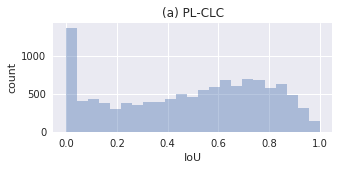

In [7]:
plclc_iou = eval_phrase_localization_plclc()
print('accuracy: %.2f' % (100 * np.sum(plclc_iou >= .5) / len(plclc_iou)))
print('avr. IoU: %.2f' % (plclc_iou.mean()))
plt.close('all')
plt.figure(figsize=(5,2))
sns.distplot(plclc_iou, kde=False)
plt.xlabel('IoU')
plt.ylabel('count')
plt.title('(a) PL-CLC')
plt.savefig('plclc-IoU.pdf', bbox_inches='tight')

IntProgress(value=0, max=11745)

accuracy: 71.20
avr. IoU: 0.60


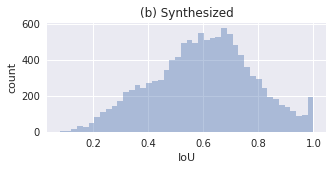

In [8]:
gt_iou = eval_phrase_localization_gtroi()
print('accuracy: %.2f' % (100 * np.sum(gt_iou > .5) / len(gt_iou)))
print('avr. IoU: %.2f' % (gt_iou.mean()))
plt.figure(figsize=(5,2))
sns.distplot(gt_iou, kde=False)
plt.xlabel('IoU')
plt.ylabel('count')
plt.title('(b) Synthesized')
plt.savefig('jitter-IoU.pdf', bbox_inches='tight')

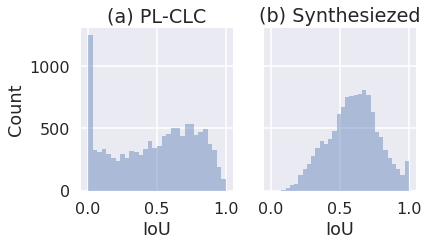

In [16]:
sns.set_context("poster")
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3), sharex=True, sharey=True)

sns.distplot(plclc_iou, kde=False, ax=ax1, bins=30)
ax1.set_title('(a) PL-CLC')
ax1.set_ylabel('Count')
ax1.set_xlabel('IoU')

sns.distplot(gt_iou, kde=False, ax=ax2, bins=30)
ax2.set_title('(b) Synthesiezed')
ax2.set_xlabel('IoU')
plt.savefig('figures/aaai/IoU_distribute.pdf', bbox_inches='tight')